[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aveusalex/AulasPDSI/blob/main/AULA1/CarregandoDados.ipynb)

# Importando bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

# Carregando dados

> Abra o link e adicione a pasta "EASY" ao seu drive, usando a opção "adicionar atalho ao drive".

https://drive.google.com/drive/folders/1cd3IEnR5gjy5URYjH1JsTK6UBij030NV?usp=share_link

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# primeiramente, devemos obter os nomes de cada arquivo

path = r"/content/drive/MyDrive/EASY" + r"/"  # altere essa string com o diretório da pasta onde os dados estão
files = listdir(path)
files

['Apneia2-99_94Hz-28R-88bpm.npz',
 'Apneia1-99_93Hz-38R-85bpm.npz',
 'Apneia4-99_94Hz-50R-69bpm.npz',
 'Apneia3-99_94Hz-13R-67bpm.npz']

> Dica: no nome de cada arquivo está descrito alguns metadados sobre cada captura:
> - a frequência de amostragem do sinal, isto é, quantos pacotes por segundo capturamos;
> - quantas respirações o infivíduo deu durante a coleta (isto é, conjunto de inspiração + expiração);
> - a frequência cardíaca média da pessoa (fora do escopo).

In [6]:
# agora basta carregar os dados utilizando o numpy
dados_easy = []  # lista que recebe os 4 arrays numpy -> [np.array, np.array...]
for file in files:
    dados_easy.append(np.load(path + file))

print(f"Quantidade de arquivos carregados: {len(dados_easy)}")

Quantidade de arquivos carregados: 4


In [7]:
# verificando se os arquivos foram carregados corretamente
error = 0
for arquivo in dados_easy:
    if arquivo.shape != (12000, 171):
        error += 1

if error != 0:
    print(f"Alguma coisa deu pau! {error} paus!")

else:
    print("Tudo certo!")

Tudo certo!


> É esperado que haja 12000 pacotes e 171 features que consideramos.

In [8]:
dados_easy[0].shape

(12000, 171)

> Confirmado!

# Entendendo o problema

Cada captura corresponde a uma coleta de respiração de uma pessoa. São 120 segundos (2 minutos) de captura, sendo os primeiros 90 segundos respirando normalmente e os últimos 30 segundos sem respirar (apneia).

Temos 12000 pacotes que corresponde a uma amostra no tempo. Podemos comparar aos quadros (fotos) que compõem um vídeo.

Desse modo, temos para cada pacote (amostra) 57 características, que corresponde a uma antena. Como na configuração dos experimentos usamos 3 antenas, temos 171 características no total. Daí o shape de cada captura é 12000 pacotes por 171 características.

Cada elemento do nosso vetor (como se fosse um pixel) é um valor complexo, isto é, é formado por um valor complexo. Vamos verificar o formato desse valor:

In [9]:
captura1 = dados_easy[0]
captura1[0, 0]

(23.999999999999996-5.0000000000000195j)

> Como pudemos ver, o valor é, na verdade, composto por dois valores:
>- um valor real, que representa a amplitude (intensidade) que a onda chegou na antena receptora;
>- um valor imaginário, que representa a fase que a onda chegou quando foi recebida na antena receptora.

## Formas de enxergar esse problema:

### Ondas (senoides) no tempo

In [9]:
# podemos ver como um conjunto de 171 ondas no tempo, ou seja, cada característica uma onda:
dados_easy[0].shape

(12000, 171)

In [10]:
# vamos plotar algumas ondas para entender melhor:
antena1_feature1 = dados_easy[0][:, 0]  # recuperando todos os 12000 pacotes da feature 1 da antena 1, para o primeiro dado
antena2_feature1 = dados_easy[0][:, 57]  # agora para a antena 2
antena3_feature1 = dados_easy[0][:, 114]  # agora para a antena 3

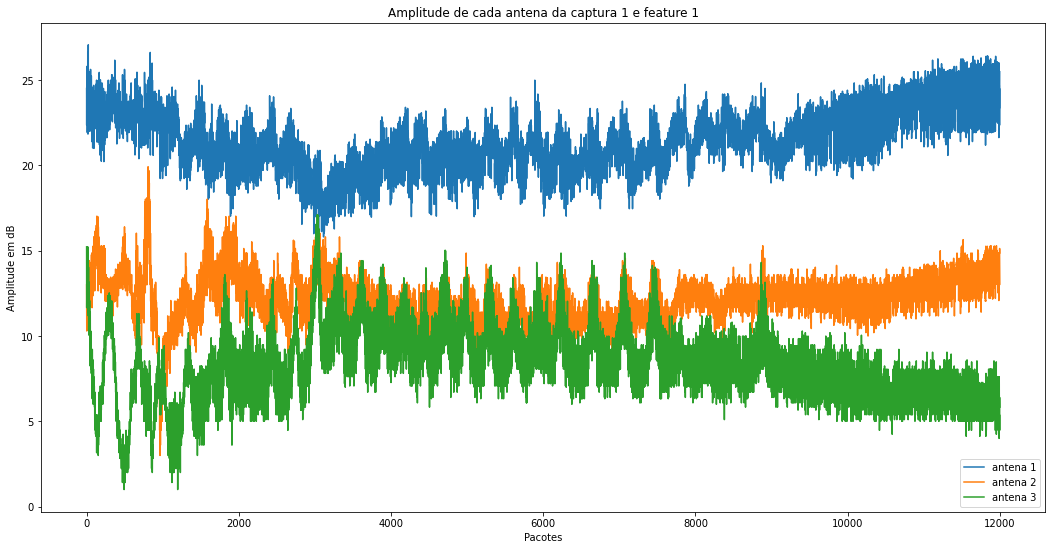

In [11]:
# plotando a amplitude (a parte real)
plt.figure(figsize=(18,9))
plt.plot(np.abs(antena1_feature1), label="antena 1")
plt.plot(np.abs(antena2_feature1), label="antena 2")
plt.plot(np.abs(antena3_feature1), label="antena 3")
plt.title("Amplitude de cada antena da captura 1 e feature 1")
plt.xlabel("Pacotes")
plt.ylabel("Amplitude em dB")
plt.legend()
plt.show()

> Como podemos ver, há diferenças entre os dados que cada antena captura.

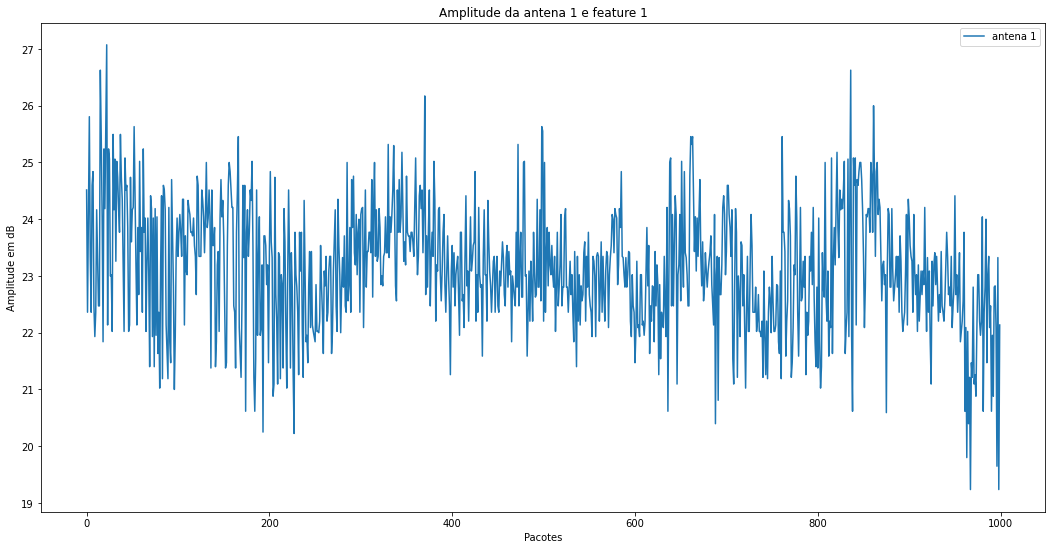

In [16]:
# vamos focar em uma antena apenas:
plt.figure(figsize=(18,9))
plt.plot(np.abs(antena1_feature1)[:1000], label="antena 1")  # recortando para uma pequena janela (ROI) da onda

plt.title("Amplitude da antena 1 e feature 1")
plt.xlabel("Pacotes")
plt.ylabel("Amplitude em dB")
plt.legend()
plt.show()

> Como podemos ver, a respiração está bem explícita nessa amostra que pegamos. Mas nem tudo são flores! Podemos perceber muito ruído presente nessa onda.

**Para facilitar, vamos criar uma função de plot para evitar código repetido:**

In [12]:
def plot_sinal(sinal, titulo="Plot personalizado"):
    plt.figure(figsize=(18,9))
    plt.plot(sinal)
    plt.title(titulo)
    plt.xlabel("Pacotes")
    plt.ylabel("Amplitude em dB")
    plt.show()

## Mãos à obra: plote novos pedaços do sinal, escolha qualquer antena, qualquer feature e qualquer pedaço (janela de pacotes) e use nossa função para plotar!

- Tips: lembre-se que nossa estrutura de dados segue o shape: 
> dados_easy-> (captura, (pacotes, features))

- Consultando a primeira captura, os pacotes 1000 a 2000 da subportadora 33:
> dados_easy[0][1000:2000, 33]

In [ ]:
# insira o código aqui

### Aplicando filtros

#### Média Móvel

A média móvel é um filtro suavizador, que é usada para suavizar os dados de uma série temporal. Ela é calculada tomando-se a média de um número específico de pontos de dados consecutivos (geralmente chamado de período ou janela) e movendo-se/deslizando essa janela ao longo da série temporal.

Também é conhecido como filtro "passa-baixas" que, como o nome sugere, só deixa passar ~baixinhos~ frequências mais baixas, que é o mesmo que dizer eliminar ruído de alta frequência!

In [13]:
def media_movel(sinal, window_size):
    weights = np.repeat(1.0, window_size)/window_size  # essa sacada aqui é interessante
    return np.convolve(sinal, weights, 'valid')

> Tips:
- O vetor weights é construído definindo, para cada valor do array (onda/sinal) um peso. Como é uma média simples, basta dividir o valor 1 pela quantidade de elementos no array. (pense, fazer a média entre dois números não é o mesmo que multiplicar cada um por 0.5 e somar seus resultados? E a média de três números? E a média de n números?)

>- A função numpy convolve é responsável por pegar o array de pesos que criamos (um filtro em si) e deslizar sobre a onda (nosso sinal). Nada mais é que um processo otimizado para aplicar o filtro.

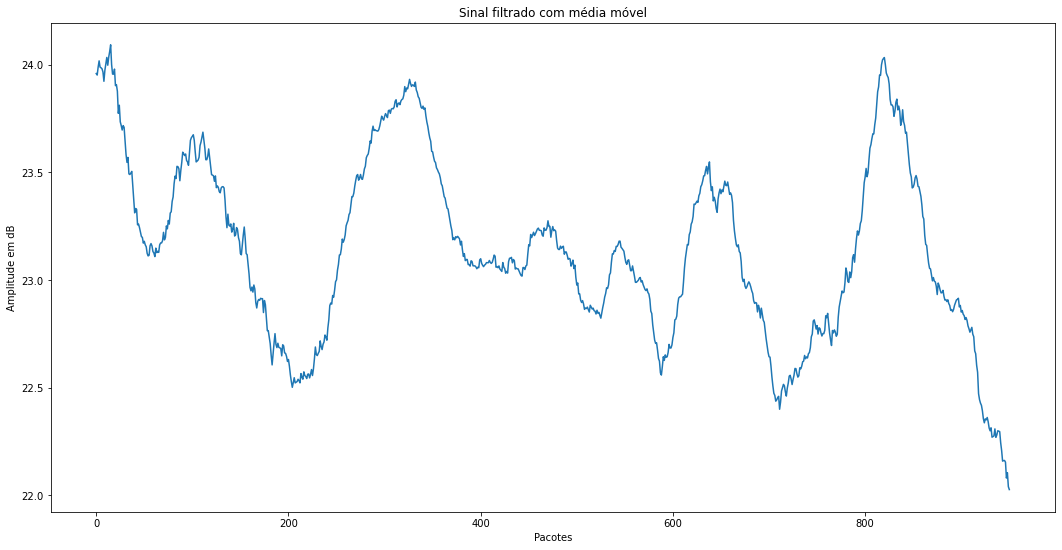

In [14]:
# vamos aplicar o filtro e verificar o impacto
sinal = np.abs(antena1_feature1)[:1000]  # o mesmo do gráfico lá de cima

novo_sinal = media_movel(sinal, window_size=50)

plot_sinal(novo_sinal, "Sinal filtrado com média móvel")

> Ficou bom ein! Bem mais suave né que o anterior.

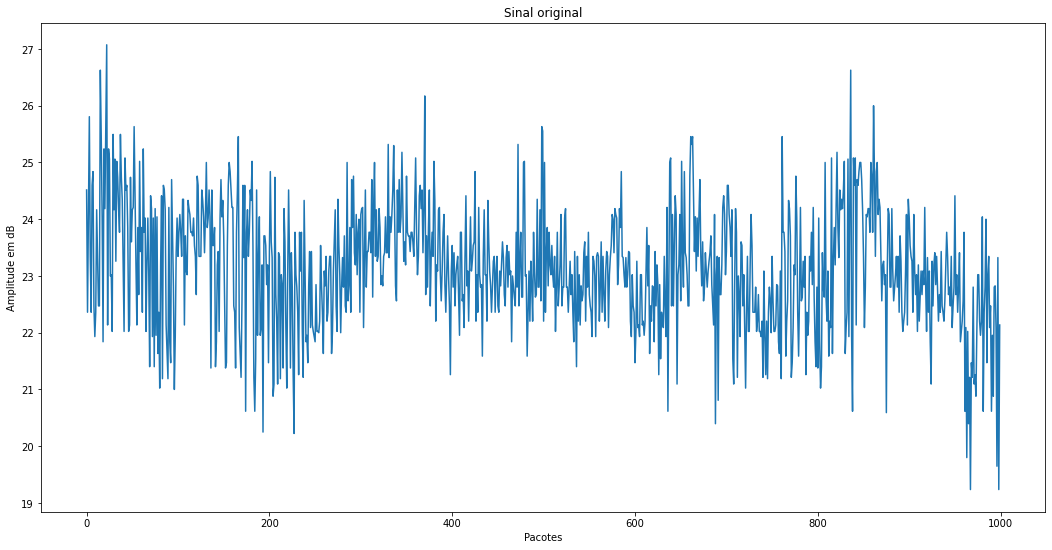

In [15]:
# plotando o antigo pra comparar
plot_sinal(sinal, "Sinal original")

> Mas parece estranho... algo não está certo... Parece que está over-estimando o comportamento do sinal. 

## Mãos na massa! Brinque com os valores do tamanho da janela da média móvel e veja o impacto no sinal:

In [ ]:
# insira o código aqui

## Filtro Hampel (ou filtro de outliers):

O filtro Hampel é um algoritmo de limpeza de dados que é usado para detectar e corrigir valores atípicos (ou outliers) em séries temporais. Ele é baseado em uma janela deslizante (como a média móvel) e usa medidas estatísticas, como a mediana e o desvio padrão, para identificar valores que são significativamente diferentes dos valores circundantes.

A operação básica do filtro Hampel é a seguinte:

- Calcular a mediana e o *median absolute deviation* para cada janela deslizante.
- Identificar valores que estão fora de um determinado limite de confiança (geralmente 3 ou 5 vezes o mad)
- Substituir esses valores atípicos pelo valor da mediana.

https://www.mathworks.com/help/dsp/ref/hampelfilter.html

In [27]:
def filtro(sinal, k=0.5):
    arr = sinal.copy()
    m = np.median(arr)
    lim_confianca = 1.4826 * np.median(np.abs(arr - np.median(arr)))
    s = np.abs(arr - m)  # calculando a diferença dos valores do arr sobre a mediana
    outliers = s > k * lim_confianca  # procurando os valores em que superam k vezes o limite de confiança 
    arr[outliers] = m  # os valores que superam são substituídos pela mediana
    return arr[arr.shape[0]//2]


def hampel(sinal, window_size):
    buffer = []
    for i in range(0, len(sinal)):
        buffer.append(filtro(sinal[i:i+window_size]))  # deslizando pelo sinal original
    
    return buffer


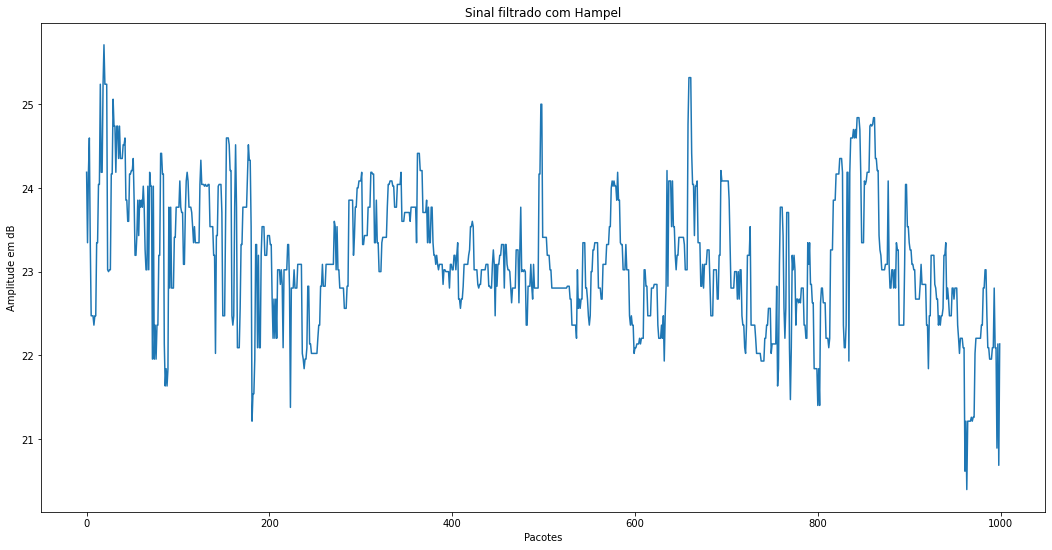

In [28]:
# vamos aplicar o filtro e verificar o impacto
sinal = np.abs(antena1_feature1)[:1000]  # o mesmo do gráfico lá de cima

novo_sinal = hampel(sinal, window_size=5)

plot_sinal(novo_sinal, "Sinal filtrado com Hampel")

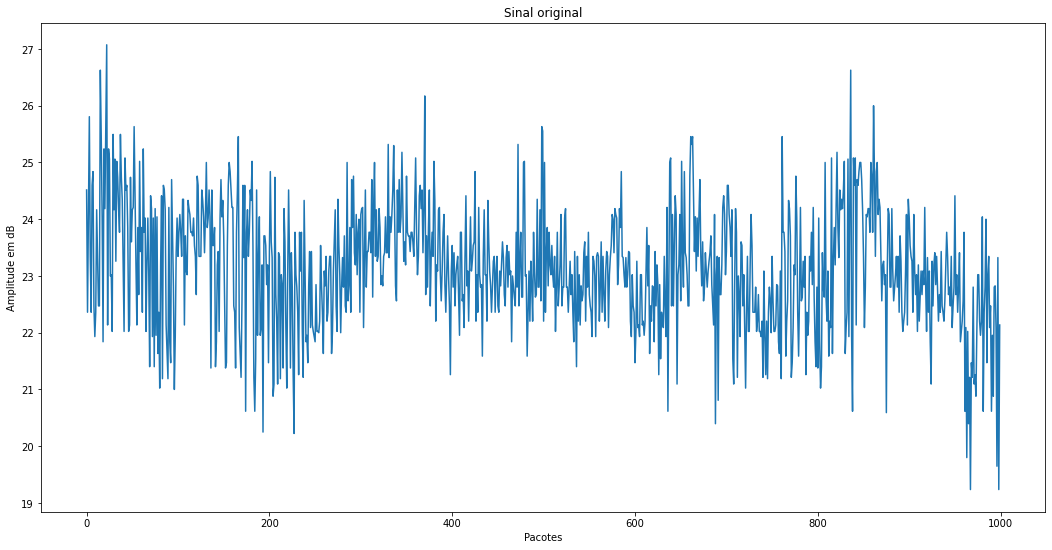

In [18]:
# plotando o antigo pra comparar
plot_sinal(sinal, "Sinal original")

## Mãos na massa! Explore, como no exercício anterior, outros sinais, experimentando mudar o tamanho da janela e o "k"

In [ ]:
# você já entendeu, código aqui

# Rodada de La Muerte:

> Agora junte tudo que vimos (janelamento e filtros) e ache a frequência de respiração dos sinais! 

- Tips: Lembre-se que as informações estão no nome dos arquivos.
- Lembre-se que o arquivo possui apneia, portanto considere o sinal apenas até o pacote 9000 (sinal[:9000]).

Boa sorte! 🍀 